<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Copy_of_Branched_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import random

In [ ]:
medium_size = 1024
x = tf.linspace(-1., 1., medium_size)
y = tf.linspace(-1., 1., medium_size)
x, y = tf.meshgrid(x, y, indexing='ij')

Generate a "disordered" medium with something like $1/f$ noise.

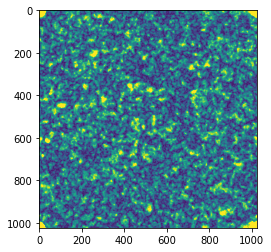

In [ ]:
u = tfp.distributions.Uniform().sample((medium_size, medium_size))
v = tfp.distributions.Uniform().sample((medium_size, medium_size))
z = (tf.cast(u, tf.complex64) + tf.cast(1.j, tf.complex64) * tf.cast(v, tf.complex64)) / tf.cast(0.001+x*x+y*y, tf.complex64)
n = tf.math.abs(tf.signal.ifft2d(z))
plt.imshow(n, vmin=0., vmax=.025)
n = 1 + 30*n

In [ ]:
def grad(z, x, y):
  dx = x[1, 0] - x[0, 0]
  dy = y[0, 1] - y[0, 0]
  return tf.stack(
    [tf.pad((z[2:, :]-z[:-2, :]) / (2. * dx), [[1, 1], [0, 0]]),
     tf.pad((z[:, 2:]-z[:, :-2]) / (2. * dy), [[0, 0], [1, 1]])],
    axis=2
  )

I'm not 100% sure of the best way to ray march a non-homogeneous medium. I derived this code using Hamiltonian style optics. It's not a symplectic integrator though

In [ ]:
def step(q0, p0):
  n0 = tfp.math.batch_interp_regular_nd_grid(q0, [-1., -1.], [1., 1.], n, axis=-2)
  gradn0 = tfp.math.batch_interp_regular_nd_grid(q0, [-1., -1.], [1., 1.], gradn, axis=-3)
  p1 = p + 0.5 * dt * (tf.einsum('ij,ij->i', p0, p0) / (n0 * n0 * n0))[:, tf.newaxis] * gradn0
  q1 = q0 + dt * p / (n0 * n0)[:, tf.newaxis]
  return (q1, p1)

In [ ]:
size = 1024
num_angles = 65536
Nsteps = 640
dt = 1 / 400.
theta = tf.linspace(0., 2 * np.pi, num_angles)
gradn = grad(n, x, y)

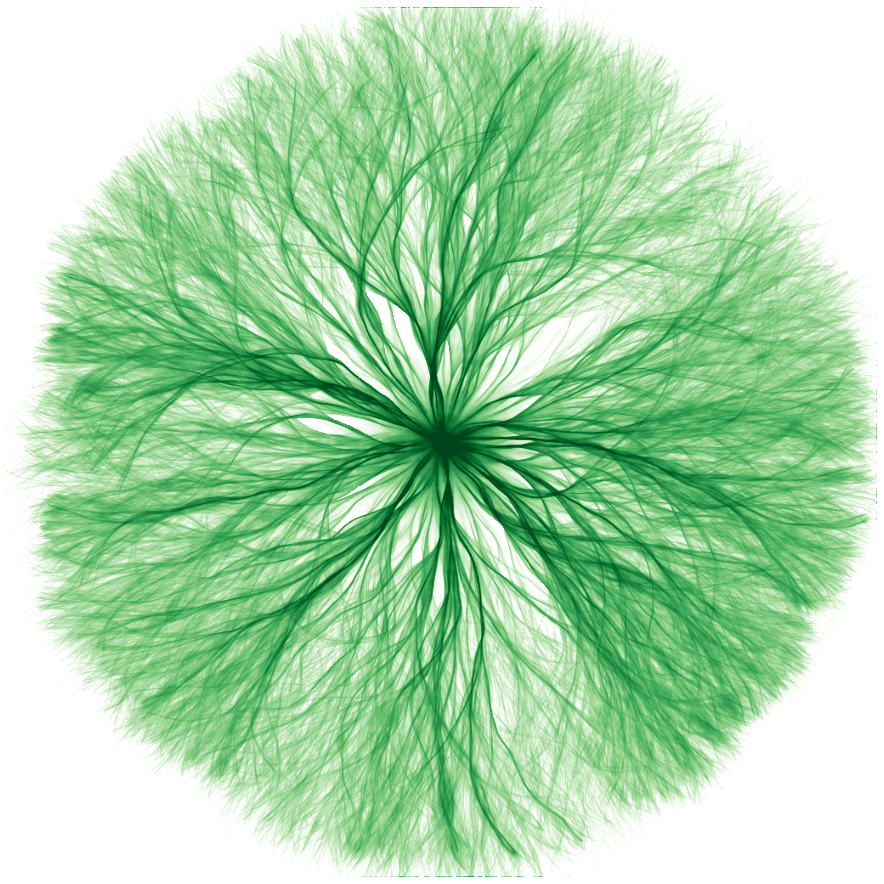

In [ ]:
q = tf.zeros((num_angles, 2))
p = tf.stack([tf.cos(theta), tf.sin(theta)], axis=1)
result = tf.zeros((size, size))
source = tf.Variable(tf.zeros((size, size)))
for i in range(0, Nsteps):
  q, p = step(q, p)
  with tf.GradientTape() as tape:
    dest = tf.reduce_sum(tfp.math.batch_interp_regular_nd_grid(q, [-1.,-1.], [1.,1.], source, axis=-2))
  image = tape.gradient(dest, source)
  result += image
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(tf.math.log(result), vmin=0, vmax=6, cmap='Greens')

In [ ]:
num_angles = 32768
NSteps = 900
theta = tf.linspace(0., 2 * np.pi, num_angles)
q1 = tf.zeros((num_angles, 2)) - [0, 0.5]
q2 = tf.zeros((num_angles, 2)) + [0, 0.5]
q = tf.concat([q1, q2], axis=0)
p = tf.stack([tf.cos(theta), tf.sin(theta)], axis=1)
p = tf.concat([p, p], axis=0)
#p = tf.stack([tf.cos(theta), tf.sin(theta)], axis=1)
result = tf.zeros((size, size))
source = tf.Variable(tf.zeros((size, size)))
for i in range(0, NSteps):
  q, p = step(q, p)
  with tf.GradientTape() as tape:
    dest = tf.reduce_sum(tfp.math.batch_interp_regular_nd_grid(q, [-1.,-1.], [1.,1.], source, axis=-2))
  image = tape.gradient(dest, source)
  result += image
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(tf.math.log(result), vmin=0, vmax=6, cmap='Greens')

KeyboardInterrupt: ignored

In [ ]:
p1 = tf.stack([tf.cos(theta)-0.5, tf.sin(theta)], axis=1)
p2 = tf.stack([tf.cos(theta)+0.5, tf.sin(theta)], axis=1)
tf.concat([p1, p2], axis=0).shape

In [ ]:
p.shape, q.shape